
--- Evaluation for: TF-IDF Only ---

Training LogisticRegression...
LogisticRegression - Accuracy: 0.91, F1: 0.95


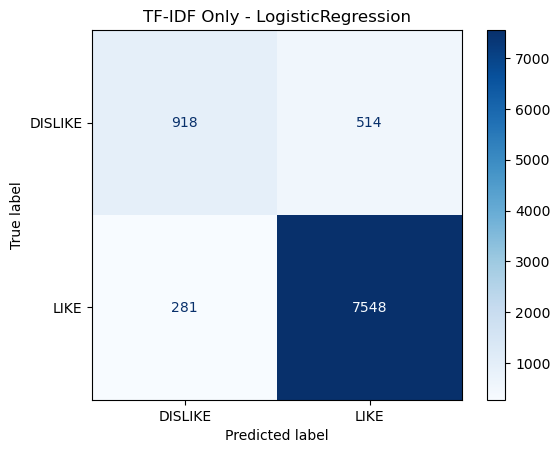


Training RandomForest...
RandomForest - Accuracy: 0.89, F1: 0.94


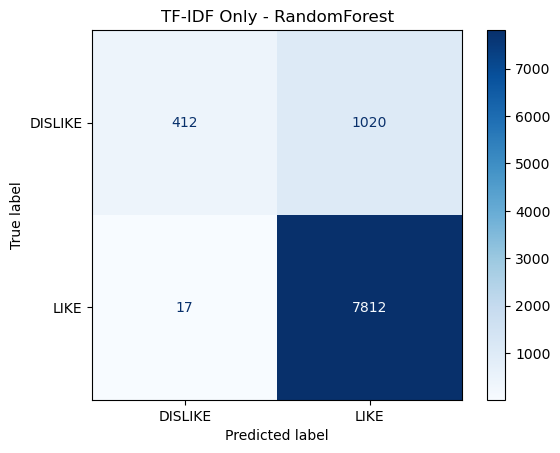


Training GaussianNB...
GaussianNB - Accuracy: 0.78, F1: 0.86


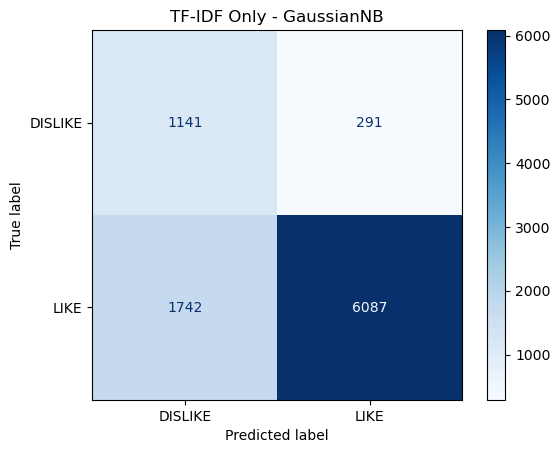


--- Evaluation for: TF-IDF + Engineered ---

Training LogisticRegression...
LogisticRegression - Accuracy: 0.91, F1: 0.95


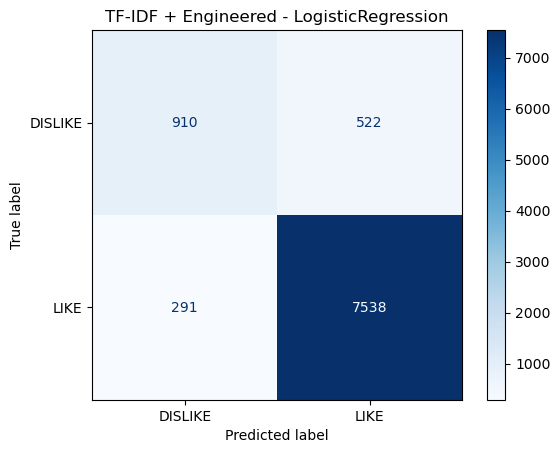


Training RandomForest...
RandomForest - Accuracy: 0.89, F1: 0.94


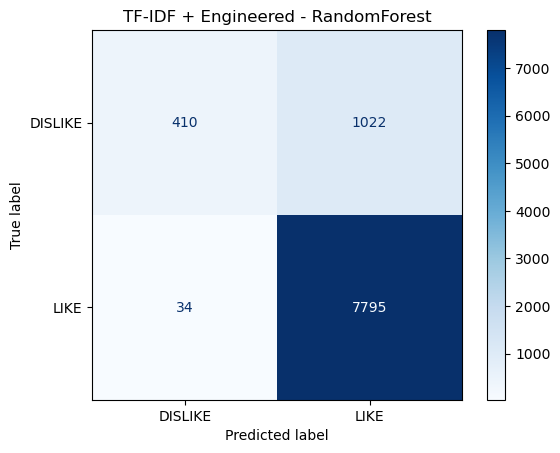


Training GaussianNB...
GaussianNB - Accuracy: 0.78, F1: 0.86


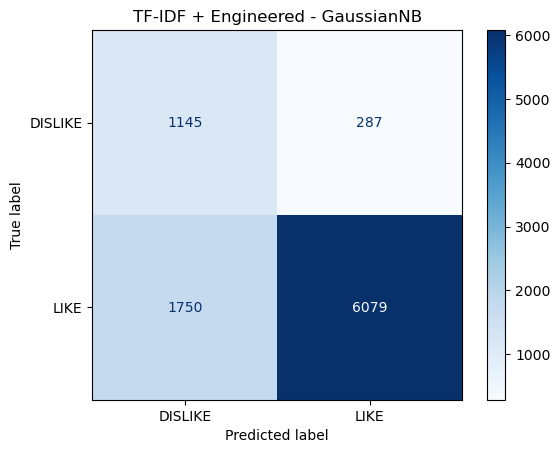


Comparison:
                Model  Accuracy_TFIDF  Precision_TFIDF  Recall_TFIDF  \
0  LogisticRegression            0.91             0.94          0.96   
1        RandomForest            0.89             0.88          1.00   
2          GaussianNB            0.78             0.95          0.78   

   F1_TFIDF                              Best Params_TFIDF  Accuracy_COMBINED  \
0      0.95  {'C': 10, 'max_iter': 1000, 'solver': 'saga'}               0.91   
1      0.94       {'max_depth': None, 'n_estimators': 100}               0.89   
2      0.86                                            n/a               0.78   

   Precision_COMBINED  Recall_COMBINED  F1_COMBINED  \
0                0.94             0.96         0.95   
1                0.88             1.00         0.94   
2                0.95             0.78         0.86   

                             Best Params_COMBINED  
0  {'C': 10, 'max_iter': 5000, 'solver': 'lbfgs'}  
1         {'max_depth': None, 'n_estimators': 50

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import scipy.sparse as sp

# --- Load & prepare data ---
df = pd.read_csv("text_features_full.csv")
df = df.sample(n=50000, random_state=42)
df = df[df['Score'] != 3]
df['Label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# --- Define features ---
engineered_features = [
    'TextLengthWords', 
    'NumUppercaseWords', 
    'AvgWordLength', 
    'ContainsNegation', 
    'TextToSummaryRatio', 
    'NumExclamations'
]

raw_text = df['Text'].astype(str)
y = df['Label']

# --- TF-IDF only representation ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(raw_text)

# --- TF-IDF + Engineered features ---
X_eng = df[engineered_features]
X_combined = sp.hstack([X_tfidf, X_eng])

# --- Train-test splits ---
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)
X_comb_train, X_comb_test, _, _ = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

# --- Model definitions ---
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'GaussianNB': GaussianNB()
}

# --- Grid search parameters ---
params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000, 5000]
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None]
    },
    'GaussianNB': {}  # geen hyperparameters voor Naive Bayes
}


# --- Evaluation loop ---
def evaluate_models(X_train, X_test, y_train, y_test, label):
    print(f"\n--- Evaluation for: {label} ---")
    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")
        best_params = "n/a"  # default for Naive Bayes
        if name == 'GaussianNB':
            # Convert sparse to dense
            X_train_dense = X_train.toarray()
            X_test_dense = X_test.toarray()
            model.fit(X_train_dense, y_train)
            y_pred = model.predict(X_test_dense)
        else:
            grid = GridSearchCV(model, params[name], scoring='f1', cv=5, n_jobs=-1)
            grid.fit(X_train, y_train)
            model = grid.best_estimator_
            best_params = grid.best_params_
            y_pred = model.predict(X_test)

        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} - Accuracy: {acc:.2f}, F1: {f1:.2f}")

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DISLIKE', 'LIKE'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{label} - {name}")
        plt.show()

        results.append({
            'Model': name,
            'Accuracy': round(acc, 2),
            'Precision': round(prec, 2),
            'Recall': round(rec, 2),
            'F1': round(f1, 2),
            'Best Params': best_params
        })

    return pd.DataFrame(results)


# Run comparisons
results_tfidf = evaluate_models(X_tfidf_train, X_tfidf_test, y_train, y_test, "TF-IDF Only")
results_combined = evaluate_models(X_comb_train, X_comb_test, y_train, y_test, "TF-IDF + Engineered")

# Compare side-by-side
comparison = results_tfidf.merge(results_combined, on="Model", suffixes=("_TFIDF", "_COMBINED"))
print("\nComparison:")
print(comparison)
print("\nComparison of Hyperparameters:")
print(comparison[['Model', 'Best Params_TFIDF', 'Best Params_COMBINED']])



Analyzing: LogisticRegression

--- Feature Importance: LogisticRegression ---
       Feature  Importance
379      great   12.779867
235  delicious   10.228141
863   terrible   10.152914
646    perfect    9.777412
294  excellent    9.515294
421   horrible    8.848088
92        best    8.703677
371       good    8.702092
39     amazing    8.657579
66       awful    8.407110
723     return    8.303933
788     smooth    8.133276
411     highly    7.888265
663    pleased    7.844690
572       nice    7.775820


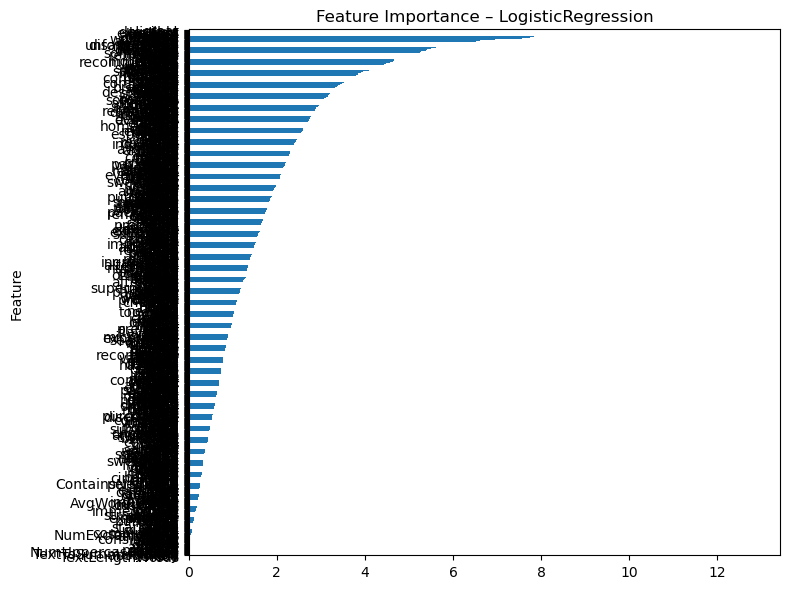


Analyzing: RandomForest

--- Feature Importance: RandomForest ---
                 Feature  Importance
580                  not    0.020940
945                  was    0.013122
379                great    0.012490
246         disappointed    0.012078
548                money    0.010343
1003    ContainsNegation    0.010265
869                  the    0.009219
1002       AvgWordLength    0.008518
863             terrible    0.008511
66                 awful    0.008069
723               return    0.008049
1004  TextToSummaryRatio    0.007995
43                   and    0.007795
1000     TextLengthWords    0.007187
421             horrible    0.007137


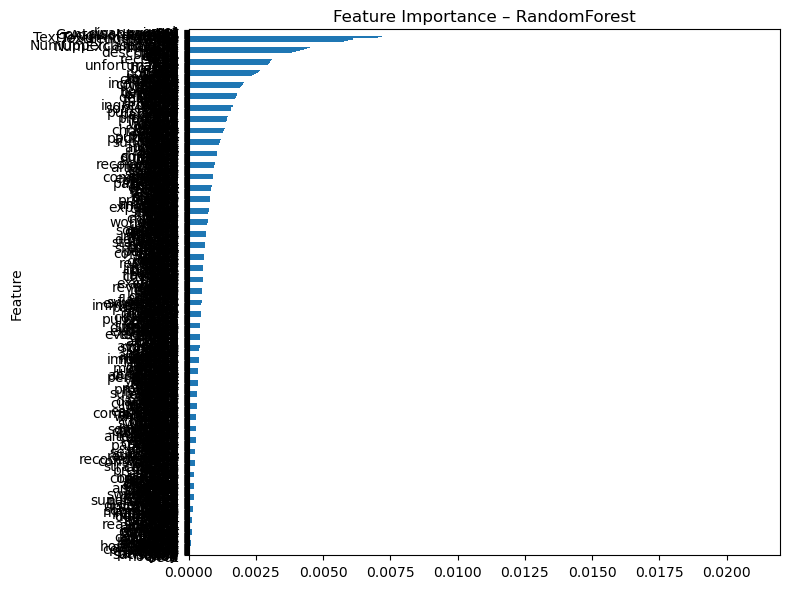


Analyzing: GaussianNB

--- Feature Importance: GaussianNB ---
                 Feature  Importance
1000     TextLengthWords   12.852575
1004  TextToSummaryRatio    1.981678
1001   NumUppercaseWords    1.156288
1003    ContainsNegation    0.245819
1005     NumExclamations    0.195211
580                  not    0.032226
1002       AvgWordLength    0.030557
945                  was    0.028841
379                great    0.025021
869                  the    0.022591
510                 love    0.016386
959                 were    0.013874
92                  best    0.012779
115                   br    0.012257
246         disappointed    0.012160


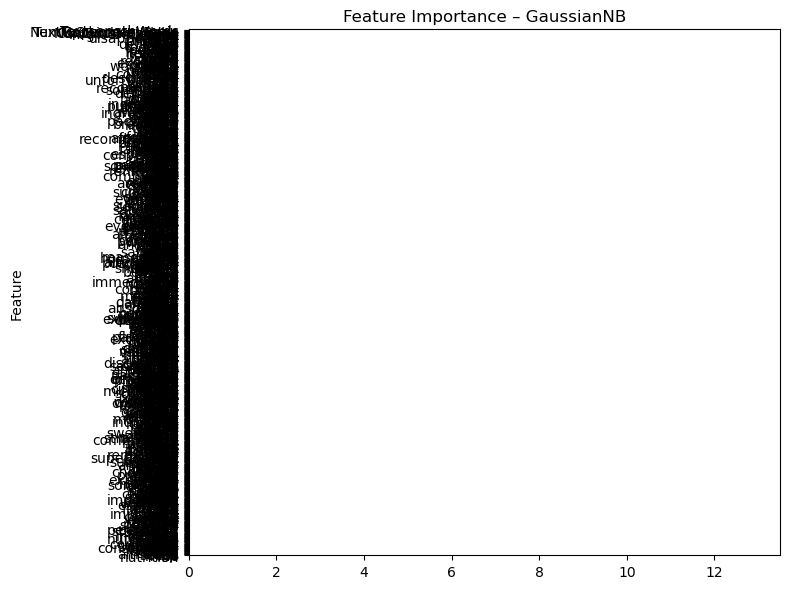

In [6]:
# --- Feature importance analysis for TF-IDF + Engineered ---
def feature_importance_analysis(model, feature_names, model_name):
    print(f"\n--- Feature Importance: {model_name} ---")
    
    if model_name == "RandomForest":
        importances = model.feature_importances_
    
    elif model_name == "LogisticRegression":
        importances = np.abs(model.coef_[0])  # absolute weights for interpretability
    
    elif model_name == "GaussianNB":
        importances = np.abs(model.theta_[1] - model.theta_[0])  # difference in class means
    
    else:
        raise ValueError("Unsupported model for feature importance.")
    
    # Combine with feature names
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    print(importance_df.head(15))  # top 15
    importance_df.plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6), legend=False)
    plt.title(f"Feature Importance – {model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Reconstruct feature names (TF-IDF + engineered)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = list(tfidf_feature_names) + engineered_features

# Fit models again on full combined data for analysis
for name, model in models.items():
    print(f"\nAnalyzing: {name}")
    if name == 'GaussianNB':
        model.fit(X_comb_train.toarray(), y_train)
    else:
        grid = GridSearchCV(model, params[name], scoring='f1', cv=5, n_jobs=-1)
        grid.fit(X_comb_train, y_train)
        model = grid.best_estimator_
    
    feature_importance_analysis(model, all_feature_names, name)
